In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
print("="*80)
print("Loading and cleaning BPI Challenge 2017 Application Log")
print("="*80)

# Load the application log
df = pd.read_csv('BPI_Challenge_2017_Application_log.csv')
# Convert timestamp column to datetime
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], format='mixed', errors='coerce')
# Sort by case ID and timestamp
df = df.sort_values(['case:concept:name', 'time:timestamp'])
# Filter to keep only 'complete' lifecycle transitions
df_clean = df[df['lifecycle:transition'] == 'complete'].copy()
# Keep only events where activity name starts with 'A_', 'O_', or 'W_', indicating valid application activities
df_clean = df_clean[
    df_clean['concept:name'].str.match(r'^[AOW]_')
].copy()

print(f"Events total: {len(df):,}")
print(f"Events after cleaning: {len(df_clean):,}")
print(f"Unique applications: {df_clean['case:concept:name'].nunique():,}")
print(f"Unique activities: {df_clean['concept:name'].nunique()}")
print(f"Unique resources: {df_clean['org:resource'].nunique()}")

# Filter only cases where Accepted == True
accepted_cases = df_clean[df_clean['Accepted'] == True]['case:concept:name'].unique()
df_clean = df_clean[df_clean['case:concept:name'].isin(accepted_cases)]

print("-"*80)
print(f"Cases with Accepted == True: {len(accepted_cases):,}")

# Now group by case and filter for cases until the concept:name == A_Accepted
df_clean = (
    df_clean
    .groupby('case:concept:name')
    .apply(
        lambda g: g.loc[:g[g['concept:name'] == 'A_Accepted'].index[0]]
        if 'A_Accepted' in g['concept:name'].values else pd.DataFrame(),
        include_groups=False,
    )
)

# bring the case id back as a normal column
df_clean = df_clean.reset_index()
if 'level_1' in df_clean.columns:
    df_clean = df_clean.drop(columns=['level_1'])

# Drop unnecessary columns
df_clean.drop(columns=['OfferID', 'lifecycle:transition', 'EventID', 'Action', 'EventOrigin', 'Unnamed: 0', 'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost',
       'Selected', 'CreditScore', 'OfferedAmount'], inplace=True)

print("="*80)

Loading and cleaning BPI Challenge 2017 Application Log
Events total: 1,202,267
Events after cleaning: 475,306
Unique applications: 31,509
Unique activities: 24
Unique resources: 144
--------------------------------------------------------------------------------
Cases with Accepted == True: 23,014


In [3]:
print("="*80)
print("Extracting the target variable from the BPI Challenge 2017 Application Log")
print("="*80)

# Load the application log
df = pd.read_csv('BPI_Challenge_2017_Application_log.csv')
# Convert timestamp column to datetime
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], format='mixed', errors='coerce')
# Sort by case ID and timestamp
df = df.sort_values(['case:concept:name', 'time:timestamp'])
# Filter to keep only 'complete' lifecycle transitions
df_clean = df[df['lifecycle:transition'] == 'complete'].copy()
# Keep only events where activity name starts with 'A_', 'O_', or 'W_', indicating valid application activities
df_clean = df_clean[
    df_clean['concept:name'].str.match(r'^[AOW]_')
].copy()

# Filter only cases where Accepted == True
accepted_cases = df_clean[df_clean['Accepted'] == True]['case:concept:name'].unique()
df_clean = df_clean[df_clean['case:concept:name'].isin(accepted_cases)]

# Group by case:concept:name and filter for cases where Selected is True or False (skipping NaN)
df_clean = df_clean.groupby('case:concept:name').filter(
    lambda g: g['Selected'].dropna().astype(bool).any() or g['Selected'].dropna().astype(bool).eq(False).all()
)

# Create a dataframe with just the case:concept:name as index and Selected columns
Target_df = df_clean.groupby('case:concept:name')['Selected'].first().to_frame()

print(f"Target cases extracted: {len(Target_df):,}")
print(f"Target distribution:")
print(Target_df['Selected'].value_counts(normalize=True))
print("="*80)

Extracting the target variable from the BPI Challenge 2017 Application Log
Target cases extracted: 23,014
Target distribution:
Selected
True     0.53676
False    0.46324
Name: proportion, dtype: float64


In [4]:
print("="*80)
print("Loading the cleaned BPI Challenge 2017 Application Log")

# Convert timestamp column to datetime
df_clean['time:timestamp'] = pd.to_datetime(df_clean['time:timestamp'], format='mixed', errors='coerce')

print("="*80)

# Feature extraction function
def extract_features(case_df):
    features = {}

    # Basic features
    features['num_events'] = len(case_df)
    features['num_resources'] = case_df['org:resource'].nunique()

    # Number of workflows
    features['num_workflows'] = case_df['concept:name'].str.startswith('W_').sum()

    # Duration in hours
    features['duration_hours'] = (case_df['time:timestamp'].max() -
                                case_df['time:timestamp'].min()).total_seconds() / 3600
    # Weekend events
    features['weekend_events'] = int((case_df['time:timestamp'].dt.dayofweek >= 5).sum())
    # Business hours events (9 AM to 5 PM)
    features['business_hours_events'] = int(((case_df['time:timestamp'].dt.hour >= 9) &
                                        (case_df['time:timestamp'].dt.hour < 17)).sum())
    # Non-business hours events
    features['non_business_hours_events'] = features['num_events'] - features['business_hours_events']
    # Average time between events in hours
    if features['num_events'] > 1:
        time_diffs = case_df['time:timestamp'].sort_values().diff().dropna()
        features['avg_time_between_events_hours'] = time_diffs.dt.total_seconds().mean() / 3600
    else:
        features['avg_time_between_events_hours'] = 0.0

    # Request amount
    features['requested_amount'] = case_df['case:RequestedAmount'].iloc[0]
    # Loan goal
    features['loan_goal'] = case_df['case:LoanGoal'].iloc[0]
    # Application type
    features['ApplicationType'] = case_df['case:ApplicationType'].iloc[0]

    return pd.Series(features)

print("="*80)
print("Extracting features")

# Feature extraction
features_df = df_clean.groupby('case:concept:name').apply(extract_features, include_groups=False).reset_index()
# One-hot encoding for loan goal
features_df = pd.get_dummies(features_df, columns=['loan_goal', 'ApplicationType'], prefix='goal')
# Handle missing values by dropping rows with any NaNs
features_df = features_df.dropna()

print("="*80)

print(f"Features extracted for {len(features_df)} applications")
print(f"Feature columns: {len(features_df.columns)}")

print("="*80)
print("Saving features for predictions")
features_df = pd.concat([features_df.set_index('case:concept:name'), Target_df], axis=1).reset_index()
features_df.to_csv('features_for_ml.csv', index=False)
print("="*80)


Loading the cleaned BPI Challenge 2017 Application Log
Extracting features
Features extracted for 23014 applications
Feature columns: 25
Saving features for predictions


Loading features for ML
Training Random Forest Classifier
Evaluating Random Forest Classifier
Classification Report:
Accuracy:  0.9194786386676321
Precision:  0.9249865083648138
Recall:  0.9249865083648138
F1 Score:  0.9249865083648138
--------------------------------------------------------------------------------
Feature Importance Plot:


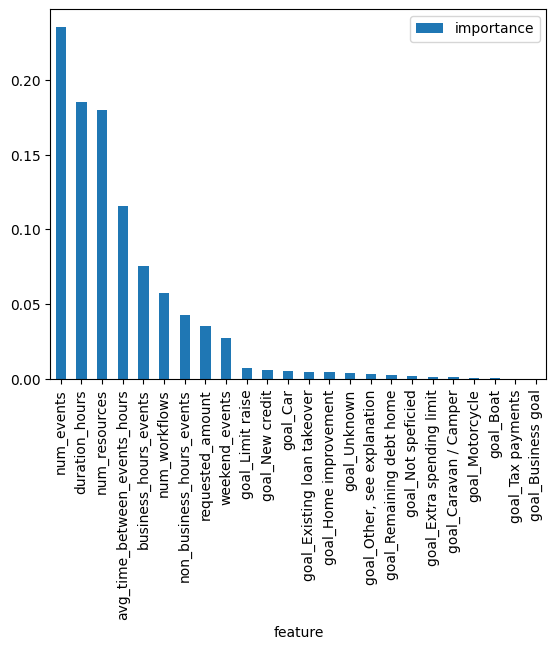

In [5]:
print("="*80)
print("Loading features for ML")

# Load features for ML
features = pd.read_csv('features_for_ml.csv', index_col=0)
# Extract features and target
X = features.drop(columns=['Selected'])
y = features['Selected'].astype(int)

print("="*80)

print("="*80)
print("Training Random Forest Classifier")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
# Train Random Forest
rf = RandomForestClassifier(n_estimators=150)
rf.fit(X_train, y_train)

print("="*80)

print("="*80)
print("Evaluating Random Forest Classifier")

# Predictions
y_pred = rf.predict(X_test)

print("="*80)

print("="*80)
print("Classification Report:")

# Detailed classification report
baseline_acc = accuracy_score(y_test, y_pred)
baseline_pr = precision_score(y_test, y_pred)
baseline_rc = recall_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)
print("Accuracy: ", baseline_acc)
print("Precision: ", baseline_pr)
print("Recall: ", baseline_rc)
print("F1 Score: ", baseline_f1)
print("-"*80)

print("Feature Importance Plot:")

# Feature importance plot
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
importances.plot(x='feature', y='importance', kind='bar')

print("="*80)
